In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import sqlite3
from iminuit import Minuit
from scipy.stats import chi2
from ExternalFunctions import nice_string_output, add_text_to_ax

matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('axes',  labelsize=20)
matplotlib.rc('font', **{'size'   : 18, 'family':'monospace'})
matplotlib.rcParams['figure.figsize'] = (12, 5)
matplotlib.rcParams['figure.titlesize'] = 22



all_dom_coordinates = pd.read_csv('/groups/icecube/debes/work/analyses/Efficiency/data/5083_DOM_coordinates_with_homemade_dom_id_from_burnsample.csv')
folder = '/groups/icecube/debes/work/analyses/Efficiency/data/burnsample_efficiency_reco/'
plot_folder = '/plots/'
plot_folder = '/groups/icecube/debes/work/analyses/Efficiency/no_GB_weights_plots'

In [3]:
ååqåqå = '/groups/icecube/debes/work/analyses/Training/stopped_through_classification/predictions/stopped_muon_prediction_on_entire_92m_events_of_burnsample_mc_and_data.csv'
q2 = '/groups/icecube/debes/work/analyses/Training/event_no_lists/list_of_data_event_nos_in_burnsample.parquet'

In [4]:
import pandas as pd

# Define the file path
file_path = '/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Burnsample_1_percent_all_events_all_variables.csv'

# Define the chunk size (adjust this according to your memory constraints)
chunk_size = 10000000  # You can adjust this value based on your available memory

# Initialize an empty list to store chunks of data
chunk_list = []

# Iterate through the chunks of the CSV file
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    chunk_list.append(chunk)

# Concatenate the list of chunks into a single DataFrame


# Now you have the DataFrame 'm2' loaded in chunks


In [5]:
pd.concatenate(chunk_list)

AttributeError: module 'pandas' has no attribute 'concatenate'

In [1]:
def divide0(y1,y2):
#    return np.divide(x.astype(np.float32),   y.astype(np.float32),  out=np.zeros_like(y).astype(np.float32), where=y!=0)
    return np.divide(y1, y2, out=np.zeros_like(y2), where=y2!=0)

def divide0err(y1,y2, sigma_y1=None, sigma_y2=None):
    value = np.divide(y1, y2, where=y2!=0)

    if sigma_y1 is None:
        sigma_y1 = np.sqrt(y1)
        print(sigma_y1)
    if sigma_y2 is None:
        sigma_y2 = np.sqrt(y2)
        print(sigma_y2)
    error = value * np.sqrt((sigma_y1/np.abs(y1))**2 + (sigma_y2/np.abs(y2))**2)

    return value, error

def sine_func(x, k, A, B, C):
        return A * np.sin(k*x+B) + C

# Initial parameter 
k_init = 1
A_init = 0.05
B_init = 3
C_init = 0.15

def fit_sine(y_data, y_err, k_guess=k_init, A_guess=A_init, B_guess=B_init, C_guess=C_init):
    def chi_square(k, A, B, C):
        y_model = sine_func(x_data, k, A, B, C)
        return np.sum((y_data - y_model) ** 2 / np.array(y_err))
    
    minuit = Minuit(chi_square, k=k_init, A=A_init, B=B_init, C=C_init)
    minuit.migrad()
    chi2_value = minuit.fval
    dof = len(x_data) - len(minuit.values)
    p_value = 1.0 - chi2.cdf(chi2_value, dof)
    d  = {
        'k':   [minuit.values['k'], minuit.errors['k']],
        'A':   [minuit.values['A'], minuit.errors['A']],
        'B':   [minuit.values['B'], minuit.errors['B']],
        'C':   [minuit.values['C'], minuit.errors['C']],
        'ndof': dof,
        'chi2': chi2_value,
        'Prob': p_value,
#        'Conv': minuit.valid
        }
    print(minuit.valid * 'Fit has converged.' + (1-minuit.valid) * 'WARNING: Fit did not converge.')

    return d


In [33]:
n_files = 20
nbins = 50
RANGE = (-np.pi,np.pi)
variable = 'photon_azimuth'

weight_with_charge = False
use_horizontal_photons = True
usecols1 = [variable, 'charge','dom_z','cherenkov_z','photon_distance','activated']
usecols2 = [variable, 'charge','dom_z','cherenkov_z','photon_distance','activated', 'GB_weights']

hs = {'bins':nbins, 'range':RANGE}

rd_all_doms_counts , rd_activated_counts ,  qrd_activated_counts  = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))
mc_all_doms_counts , mc_activated_counts ,  qmc_activated_counts  = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))
mct_all_doms_counts, mct_activated_counts,  qmct_activated_counts = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))

for i in range(n_files):
    rd_path  = folder+'4k_rd_photon_efficiency_reco_'+str(i)+'.parquet'
    mc_path  = folder+'4k_mc_photon_efficiency_reco_'+str(i)+'.parquet'
    mct_path = folder+'4k_mc_truth_photon_efficiency_reco_'+str(i)+'.parquet'

    rd =  pd.read_parquet(rd_path, columns=usecols1) 
    mc =  pd.read_parquet(mc_path, columns=usecols2)
    mct = pd.read_parquet(mct_path, columns=usecols2)

    mc['GB_weights']  = mc['GB_weights'].apply(lambda x: min(x, 40))
    mct['GB_weights'] = mct['GB_weights'].apply(lambda x: min(x, 40))

    # Choose photons closer than 100m
    rd = rd[rd['photon_distance']<100]
    mc = mc[mc['photon_distance']<100]
    mct = mct[mct['photon_distance']<100]

    # Choose horizontal photons
    if use_horizontal_photons:
        rd  =  rd[np.abs(rd['dom_z'] - rd['cherenkov_z'])<10]
        mc  =  mc[np.abs(mc['dom_z'] - mc['cherenkov_z'])<10]
        mct = mct[np.abs(mct['dom_z']- mct['cherenkov_z'])<10]
    
    ###### Photon distance histograms ######
    qrdcount, _        = np.histogram(rd[rd['activated'] == 1][variable], **hs,   weights=rd[rd['activated'] == 1]['charge'])
    rdcount, bin_edges = np.histogram(rd[rd['activated'] == 1][variable], **hs)
    rdcount2, _        = np.histogram(rd[variable], **hs)
    
    qmccount, _        = np.histogram(mc[mc['activated'] == 1][variable], **hs, weights=mc[mc['activated'] == 1]['charge']  *  mc[mc['activated'] == 1]['GB_weights'])
    mccount, _         = np.histogram(mc[mc['activated'] == 1][variable], **hs, weights=mc[mc['activated'] == 1]['GB_weights'])
    mccount2, _        = np.histogram(mc[variable], **hs,  weights=mc['GB_weights'])
    
    qmctcount, _       = np.histogram(mct[mct['activated'] == 1][variable], **hs, weights=mct[mct['activated'] == 1]['charge'] * mct[mct['activated'] == 1]['GB_weights'])
    mctcount, _        = np.histogram(mct[mct['activated'] == 1][variable], **hs, weights=mct[mct['activated'] == 1]['GB_weights'])
    mctcount2, _       = np.histogram(mct[variable], **hs,  weights=mct['GB_weights'])
    
    rd_activated_counts[i] , qrd_activated_counts[i] , rd_all_doms_counts[i]  = rdcount , qrdcount , rdcount2
    mc_activated_counts[i] , qmc_activated_counts[i] , mc_all_doms_counts[i]  = mccount , qmccount , mccount2
    mct_activated_counts[i], qmct_activated_counts[i], mct_all_doms_counts[i] = mctcount, qmctcount, mctcount2


bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
x_data = bin_centers


In [2]:
rd_activated , qrd_activated , rd_all_doms  = np.sum(rd_activated_counts,  axis=0), np.sum(qrd_activated_counts,  axis=0), np.sum(rd_all_doms_counts, axis=0)
mc_activated , qmc_activated , mc_all_doms  = np.sum(mc_activated_counts,  axis=0), np.sum(qmc_activated_counts,  axis=0), np.sum(mc_all_doms_counts, axis=0)
mct_activated, qmct_activated, mct_all_doms = np.sum(mct_activated_counts, axis=0), np.sum(qmct_activated_counts, axis=0), np.sum(mct_all_doms_counts, axis=0)

rdeff , rdeff_err  = divide0err(rd_activated, rd_all_doms)
mceff , mceff_err  = divide0err(mc_activated, mc_all_doms)
mcteff, mcteff_err = divide0err(mct_activated, mct_all_doms)

mcrdeff, mcrdeff_err   = divide0err(mceff, rdeff, mceff_err, rdeff_err)
mctrdeff, mctrdeff_err = divide0err(mcteff, rdeff, mcteff_err, rdeff_err)

qrdeff , qrdeff_err  = divide0err(qrd_activated, rd_all_doms)
qmceff , qmceff_err  = divide0err(qmc_activated, mc_all_doms)
qmcteff, qmcteff_err = divide0err(qmct_activated, mct_all_doms)

qmcrdeff,  qmcrdeff_err = divide0err(qmceff, qrdeff, qmceff_err, qrdeff_err)
qmctrdeff, qmctrdeff_err = divide0err(qmcteff, qrdeff, qmcteff_err, qrdeff_err)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
x_data = bin_centers

NameError: name 'np' is not defined

# Without charge

Fit has converged.
Fit has converged.
Fit has converged.


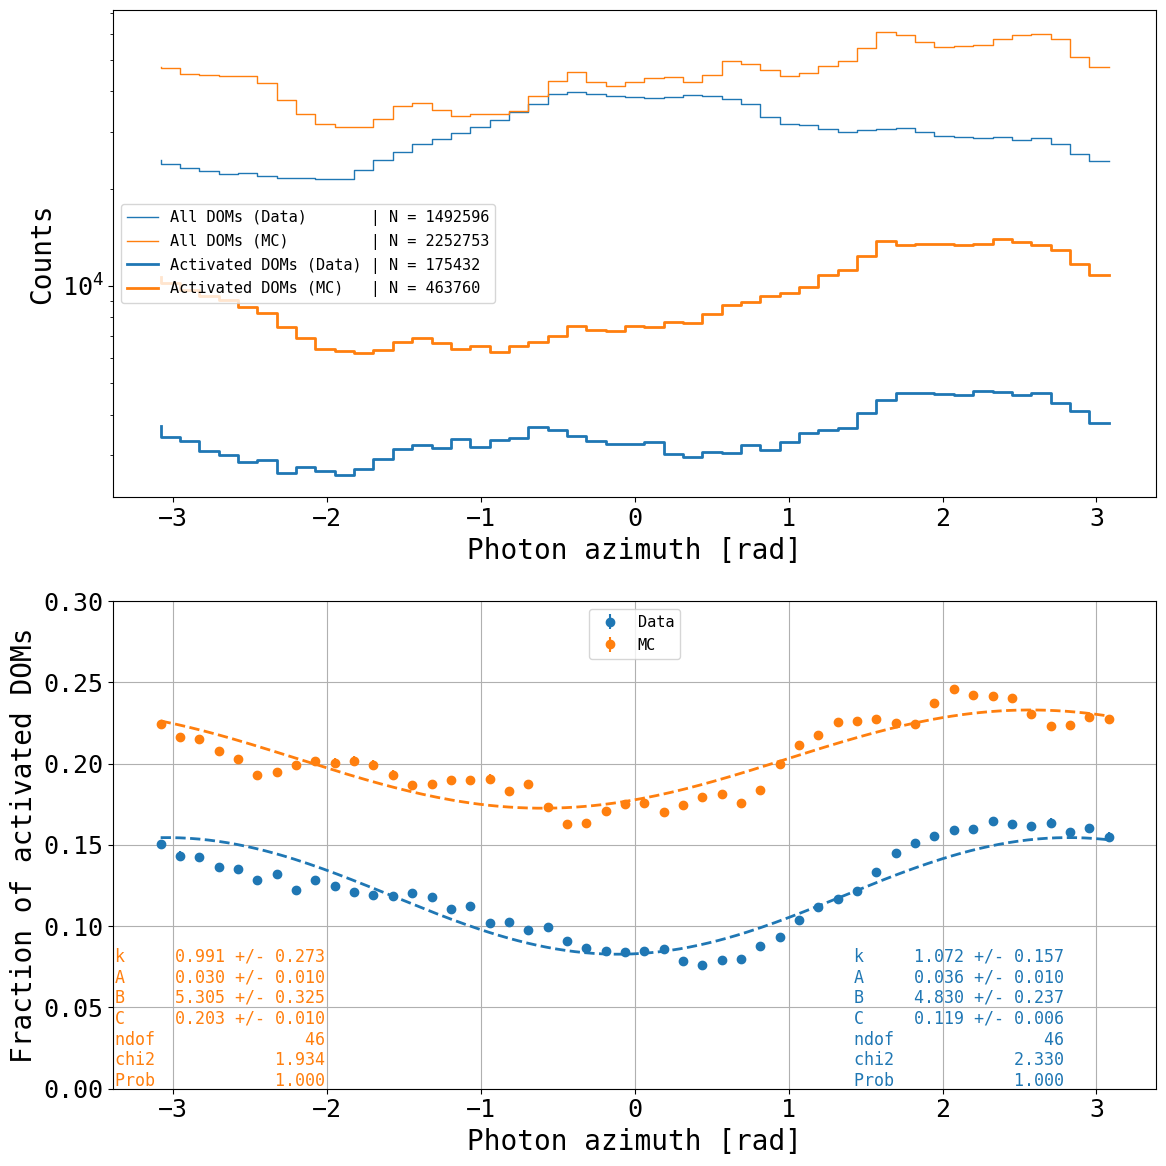

In [38]:

rd_d = fit_sine(rdeff, rdeff_err)
mc_d = fit_sine(mceff, mceff_err)
mct_d = fit_sine(mcteff, mcteff_err)


hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
c1, c2, c3 = 'C00', 'C01', 'black'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00', label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01', label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
#ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color=c3,  label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mct_all_doms)))

ax[0].step(bin_centers, rd_activated,  where=where, linewidth=2, color='C00', label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(bin_centers, mc_activated,  where=where, linewidth=2, color='C01', label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
#ax[0].step(bin_centers, mct_activated, where=where, linewidth=2, color=c3,  label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'Photon azimuth [rad]', ylabel = 'Counts', yscale='log')
#ax[0].grid()

X = bin_centers#np.linspace(-np.pi,np.pi, nbins)
X2 = np.linspace(bin_centers[0], bin_centers[-1], 200)#np.linspace(-np.pi,np.pi, nbins)


fs = 12
ax[1].errorbar(X, rdeff, yerr=rdeff_err, color=c1, fmt ='o', label='Data')
ax[1].errorbar(X, mceff, yerr=mceff_err, color=c2, fmt ='o', label='MC')
#ax[1].errorbar(X, mcteff, yerr=mcteff_err, color=c3, fmt ='o', label='Truth')
yval = 0.29
d = rd_d
ax[1].plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.71, yval, text, ax[1], fontsize=fs, color=c1)

d = mc_d
ax[1].plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.002, yval, text, ax[1], fontsize=fs, color=c2)

ax[1].legend(fontsize=11)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon azimuth [rad]', ylabel = 'Fraction of activated DOMs', ylim=(-0.0,0.3))
ax[1].legend(fontsize=11, loc = 'upper center')
ax[1].grid()
plt.tight_layout()
if savefig:
    plt.savefig(plot_folder+'azimuth_efficiency_horizontal_vs_truth.pdf')
plt.show()

# Without charge vs truth

Fit has converged.
Fit has converged.
Fit has converged.


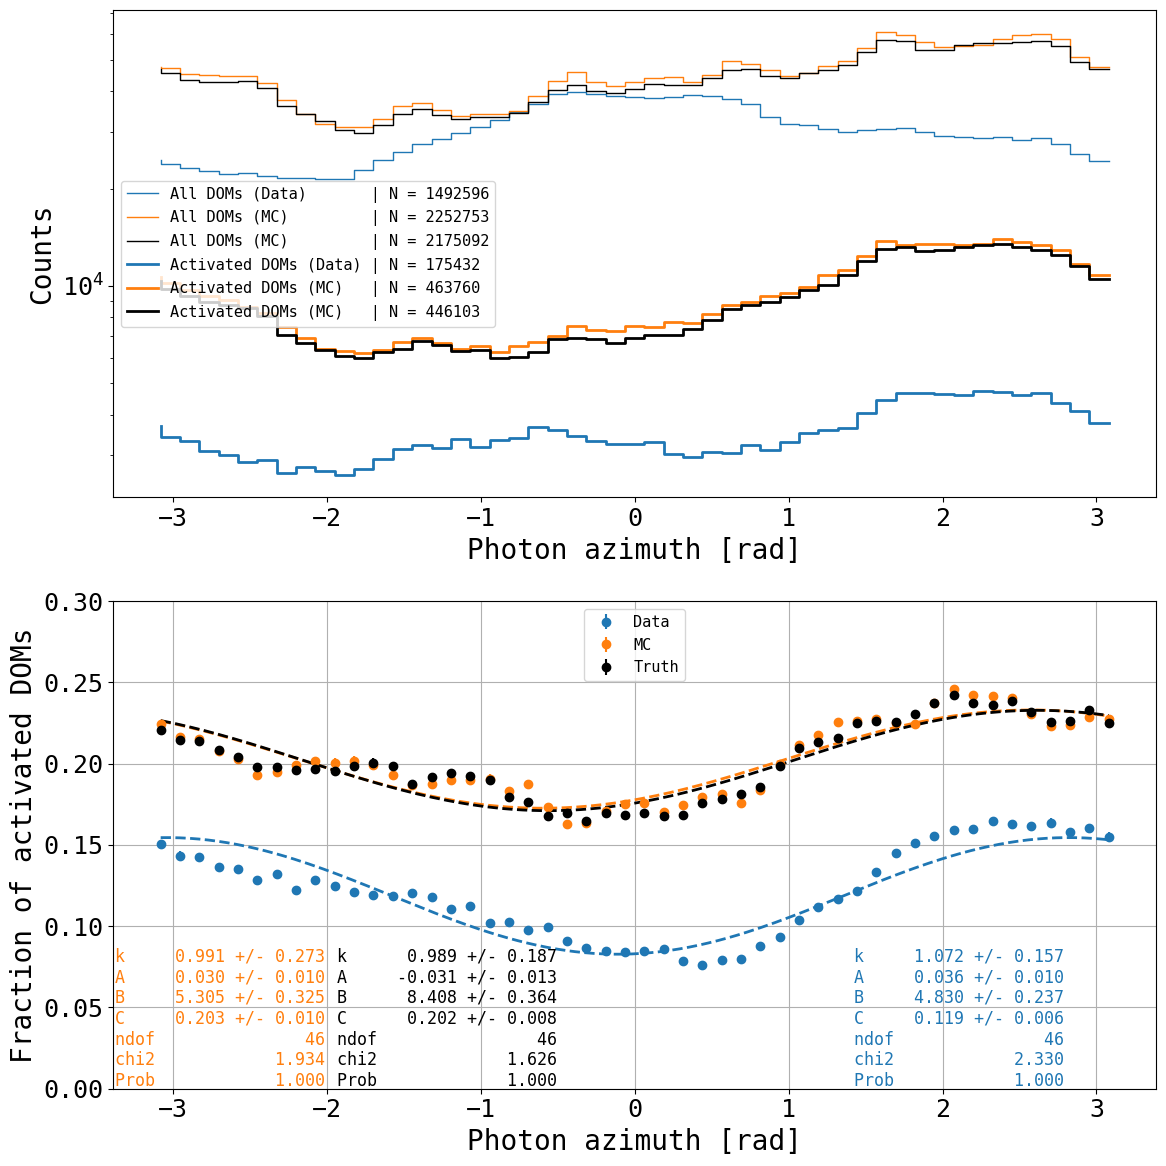

In [39]:
rd_d = fit_sine(rdeff, rdeff_err)
mc_d = fit_sine(mceff, mceff_err)
mct_d = fit_sine(mcteff, mcteff_err)


hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
c1, c2, c3 = 'C00', 'C01', 'black'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00', label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01', label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color=c3,  label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mct_all_doms)))

ax[0].step(bin_centers, rd_activated,  where=where, linewidth=2, color='C00', label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(bin_centers, mc_activated,  where=where, linewidth=2, color='C01', label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
ax[0].step(bin_centers, mct_activated, where=where, linewidth=2, color=c3,  label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'Photon azimuth [rad]', ylabel = 'Counts', yscale='log')
#ax[0].grid()

X = bin_centers#np.linspace(-np.pi,np.pi, nbins)
X2 = np.linspace(bin_centers[0], bin_centers[-1], 200)#np.linspace(-np.pi,np.pi, nbins)


fs = 12
ax[1].errorbar(X, rdeff, yerr=rdeff_err, color=c1, fmt ='o', label='Data')
ax[1].errorbar(X, mceff, yerr=mceff_err, color=c2, fmt ='o', label='MC')
ax[1].errorbar(X, mcteff, yerr=mcteff_err, color=c3, fmt ='o', label='Truth')
yval = 0.29
d = rd_d
ax[1].plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.71, yval, text, ax[1], fontsize=fs, color=c1)

d = mc_d
ax[1].plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.002, yval, text, ax[1], fontsize=fs, color=c2)

d = mct_d
ax[1].plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c3, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.215, yval, text, ax[1], fontsize=fs, color=c3)

ax[1].legend(fontsize=11)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon azimuth [rad]', ylabel = 'Fraction of activated DOMs', ylim=(-0.0,0.3))
ax[1].legend(fontsize=11, loc = 'upper center')
ax[1].grid()
plt.tight_layout()
if savefig:
    plt.savefig(plot_folder+'azimuth_efficiency_horizontal_vs_truth.pdf')
plt.show()

# MC/Data without charge

Fit has converged.
Fit has converged.


[Text(0.5, 0, 'Photon azimuth [rad]'), Text(0, 0.5, 'Charge ratio')]

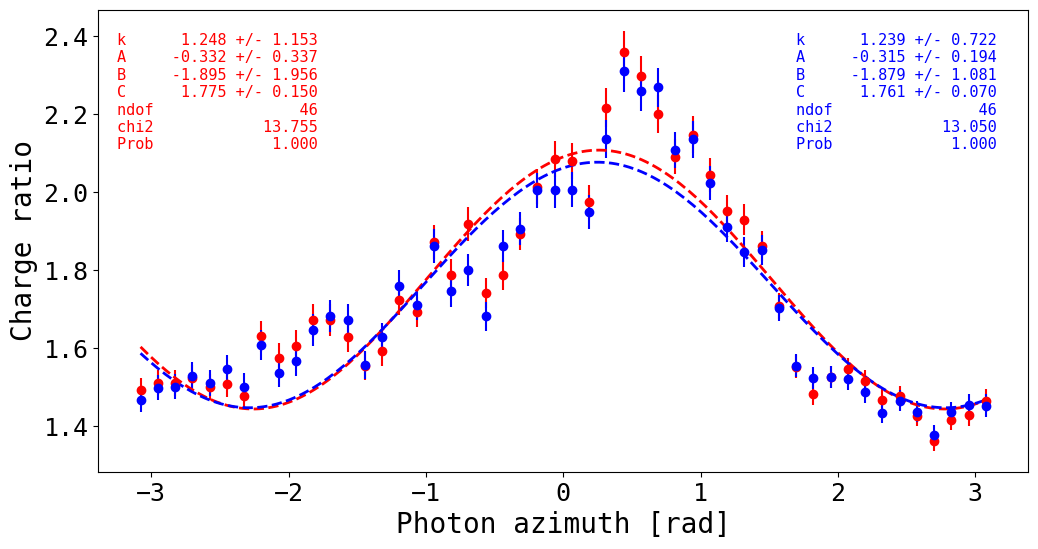

In [40]:
# Slet denne 
A_init = 0.5
k_init = 2
B_init = -1
C_init = 1


mcrd_d  = fit_sine(mcrdeff,  mcrdeff_err)
mctrd_d = fit_sine(mctrdeff, mctrdeff_err)

X = bin_centers#np.linspace(-np.pi,np.pi, nbins)
X2 = np.linspace(bin_centers[0], bin_centers[-1],200)#np.linspace(-np.pi,np.pi, nbins)
fig, ax = plt.subplots(1,1, figsize=(12,6))
c1, c2 = 'r', 'b'
ax.errorbar(X, mcrdeff,  yerr=mcrdeff_err, color=c1, fmt ='o', label='MC/Data');
ax.errorbar(X, mctrdeff, yerr=mctrdeff_err, color=c2, fmt ='o', label='Truth/Data')

d = mcrd_d
ax.plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=11, color=c1)

d = mctrd_d
ax.plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.75, 0.95, text, ax, fontsize=11, color=c2)

ax.set(xlabel = 'Photon azimuth [rad]', ylabel = 'Charge ratio')
# ax.legend(fontsize=11), ax.grid(), plt.tight_layout()
#if savefig:
#    plt.savefig(plot_folder+'azimuth_charge_ratios.pdf')

# With charge

Fit has converged.
Fit has converged.
Fit has converged.


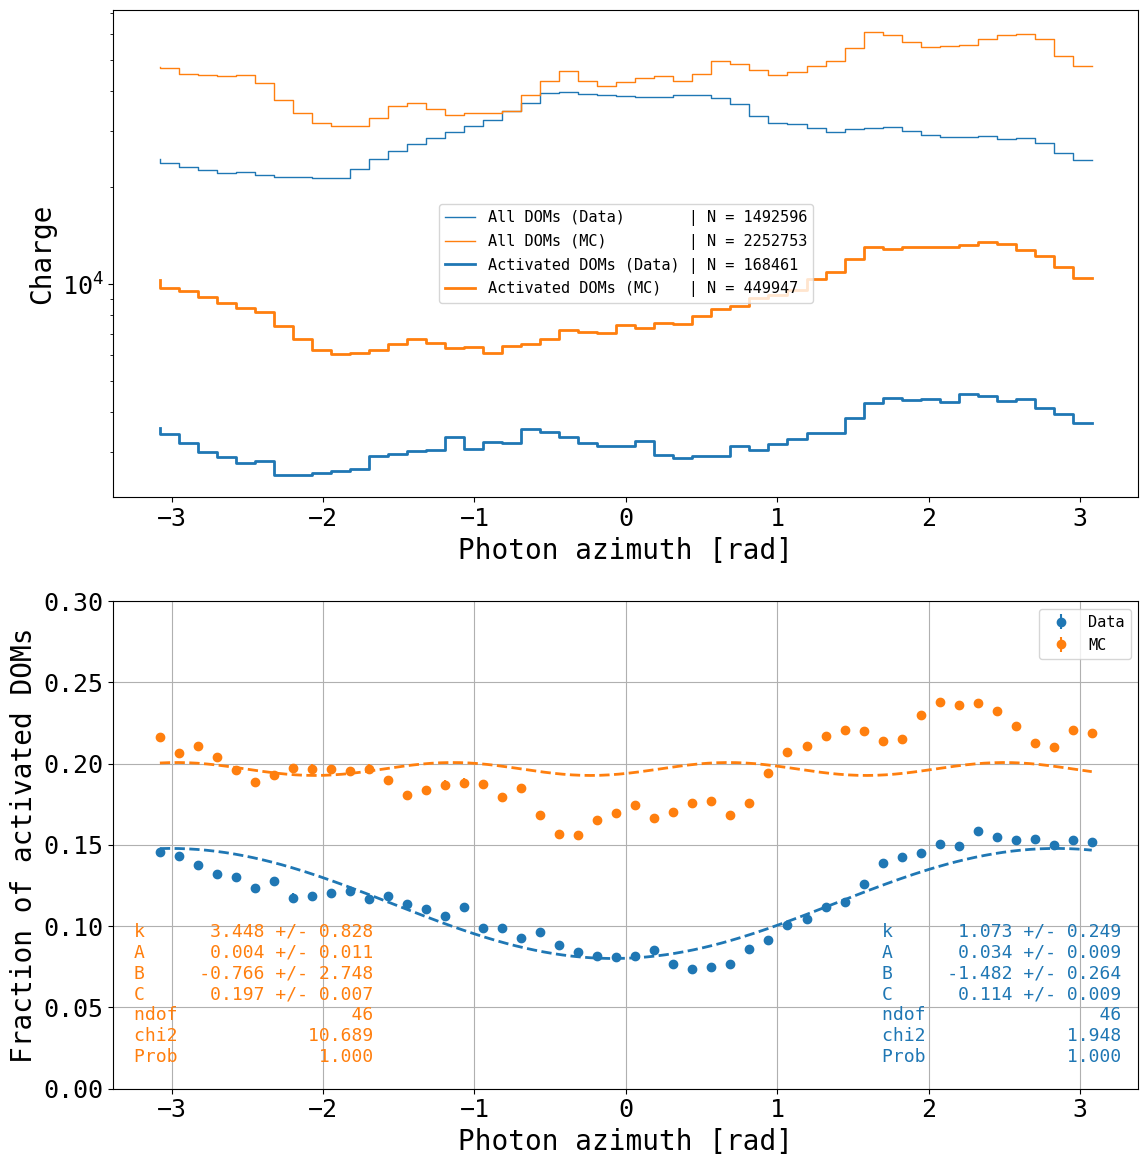

In [41]:
qrd_d = fit_sine(qrdeff, qrdeff_err)
qmc_d = fit_sine(qmceff, qmceff_err)
qmct_d = fit_sine(qmcteff, qmcteff_err)


hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))

ax[0].step(bin_centers, qrd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(qrd_activated)))
ax[0].step(bin_centers, qmc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmc_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'Photon azimuth [rad]', ylabel = 'Charge', yscale='log')
#ax[0].grid()

X = bin_centers#np.linspace(-np.pi,np.pi, nbins)
X2 = np.linspace(bin_centers[0], bin_centers[-1], 200)#np.linspace(-np.pi,np.pi, nbins)

c1, c2 = 'C00', 'C01'
fs = 13
ax[1].errorbar(X, qrdeff, yerr=qrdeff_err, color=c1, fmt ='o', label='Data');
ax[1].errorbar(X, qmceff, yerr=qmceff_err, color=c2, fmt ='o', label='MC')

d = qrd_d
ax[1].plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.75, 0.34, text, ax[1], fontsize=fs, color=c1)

d = qmc_d
ax[1].plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.34, text, ax[1], fontsize=fs, color=c2)

ax[1].legend(fontsize=11)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon azimuth [rad]', ylabel = 'Fraction of activated DOMs', ylim=(0.0,0.3))
ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
if savefig:
    plt.savefig(plot_folder+'azimuth_with_charge_efficiency_horizontal.pdf')
plt.show()

# With charge vs truth

Fit has converged.
Fit has converged.
Fit has converged.


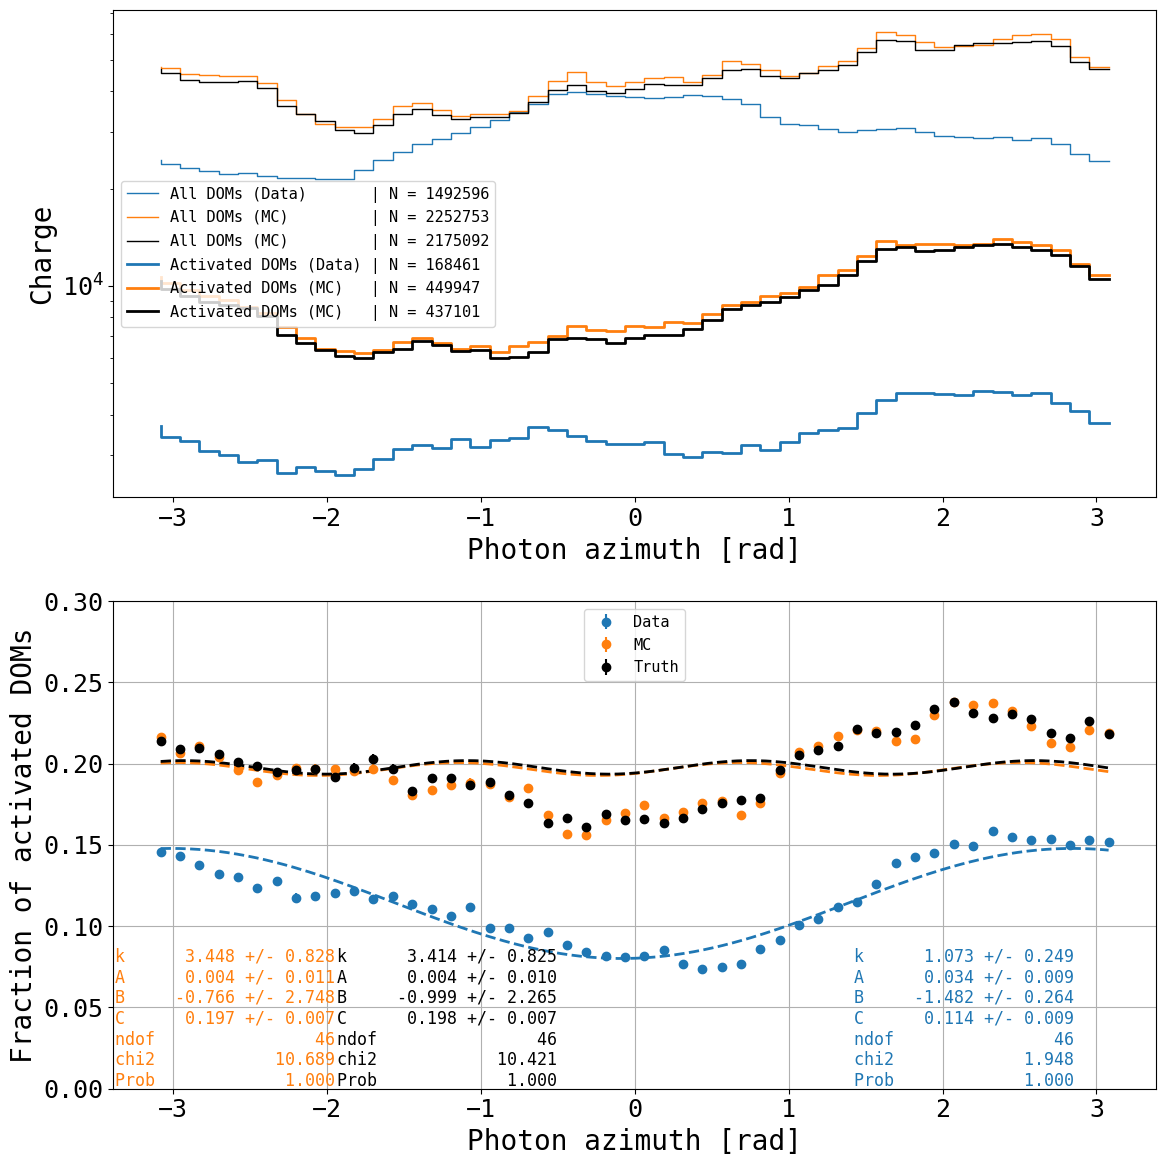

In [42]:
rd_d = fit_sine(qrdeff, qrdeff_err)
mc_d = fit_sine(qmceff, qmceff_err)
mct_d = fit_sine(qmcteff, qmcteff_err)


hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
c1, c2, c3 = 'C00', 'C01', 'black'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00', label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01', label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color=c3,  label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mct_all_doms)))

ax[0].step(bin_centers, rd_activated,  where=where, linewidth=2, color='C00', label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(qrd_activated)))
ax[0].step(bin_centers, mc_activated,  where=where, linewidth=2, color='C01', label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmc_activated)))
ax[0].step(bin_centers, mct_activated, where=where, linewidth=2, color=c3,  label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'Photon azimuth [rad]', ylabel = 'Charge', yscale='log')
#ax[0].grid()

X = bin_centers#np.linspace(-np.pi,np.pi, nbins)
X2 = np.linspace(bin_centers[0], bin_centers[-1], 200)#np.linspace(-np.pi,np.pi, nbins)


fs = 12
ax[1].errorbar(X, qrdeff, yerr=qrdeff_err, color=c1, fmt ='o', label='Data')
ax[1].errorbar(X, qmceff, yerr=qmceff_err, color=c2, fmt ='o', label='MC')
ax[1].errorbar(X, qmcteff, yerr=qmcteff_err, color=c3, fmt ='o', label='Truth')
yval = 0.29
d = rd_d
ax[1].plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.71, yval, text, ax[1], fontsize=fs, color=c1)

d = mc_d
ax[1].plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.002, yval, text, ax[1], fontsize=fs, color=c2)

d = mct_d
ax[1].plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c3, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.215, yval, text, ax[1], fontsize=fs, color=c3)

ax[1].legend(fontsize=11)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon azimuth [rad]', ylabel = 'Fraction of activated DOMs', ylim=(-0.0,0.3))
ax[1].legend(fontsize=11, loc = 'upper center')
ax[1].grid()
plt.tight_layout()
if savefig:
    plt.savefig(plot_folder+'azimuth_with_charge_efficiency_horizontal_vs_truth.pdf')
plt.show()

Fit has converged.
Fit has converged.
Fit has converged.
Fit has converged.


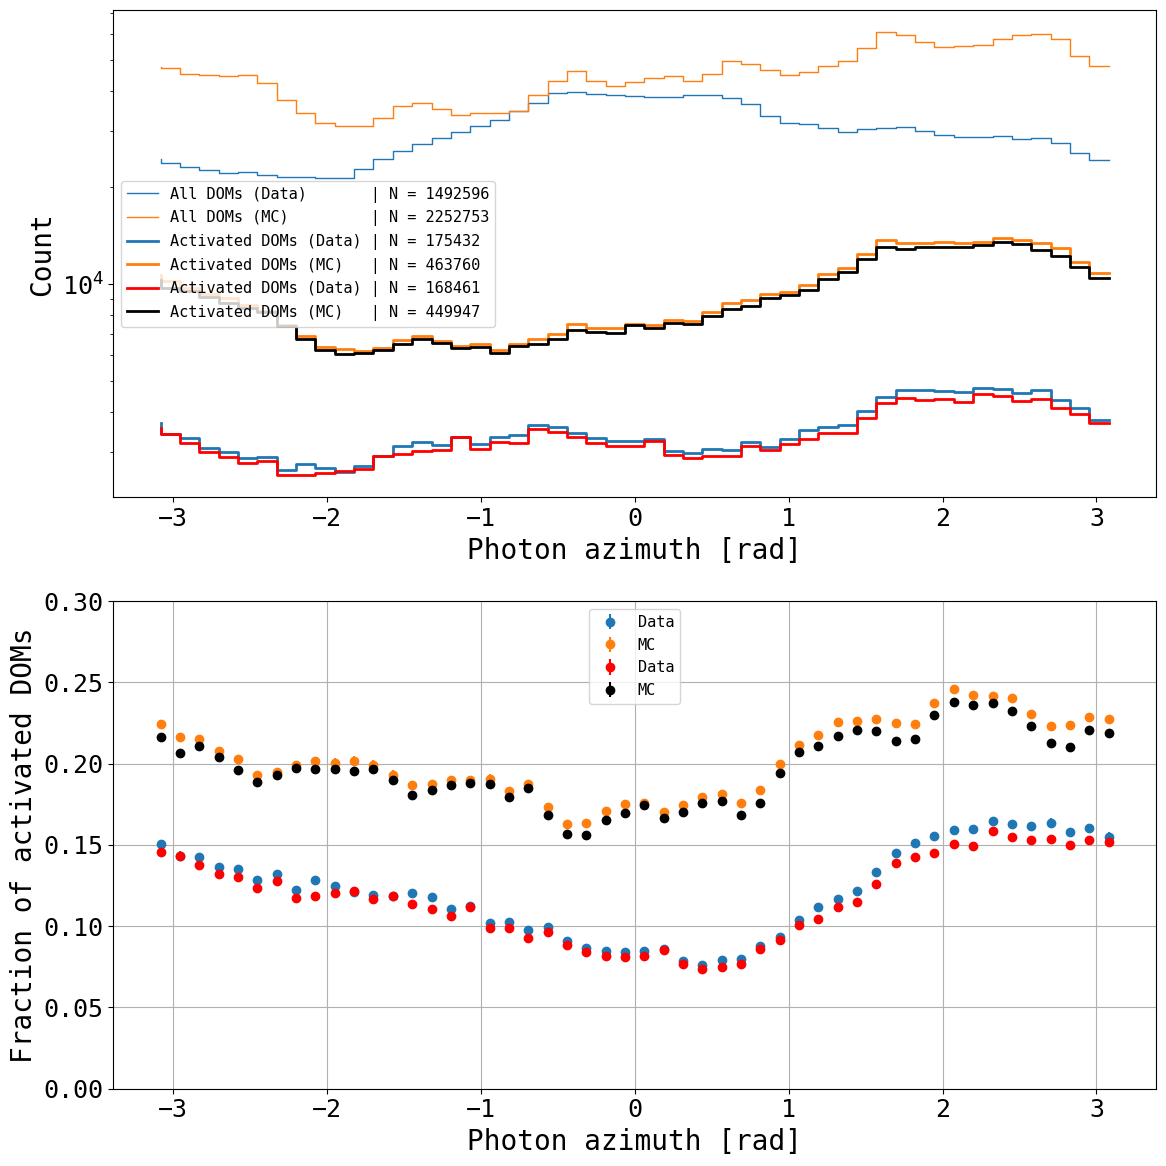

In [44]:
rd_d = fit_sine(rdeff, rdeff_err)
mc_d = fit_sine(mceff, mceff_err)

qrd_d = fit_sine(qrdeff, qrdeff_err)
qmc_d = fit_sine(qmceff, qmceff_err)


hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
c1, c2, c3 = 'C00', 'C01', 'black'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00', label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01', label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))

ax[0].step(bin_centers, rd_activated,  where=where, linewidth=2, color='C00', label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(bin_centers, mc_activated,  where=where, linewidth=2, color='C01', label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
ax[0].step(bin_centers, qrd_activated, where=where, linewidth=2, color='r',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(qrd_activated)))
ax[0].step(bin_centers, qmc_activated, where=where, linewidth=2, color='k',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmc_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'Photon azimuth [rad]', ylabel = 'Count', yscale='log')
#ax[0].grid()

X = bin_centers#np.linspace(-np.pi,np.pi, nbins)
X2 = np.linspace(bin_centers[0], bin_centers[-1], 200)#np.linspace(-np.pi,np.pi, nbins)


fs = 12
ax[1].errorbar(X, rdeff, yerr=rdeff_err, color=c1, fmt ='o', label='Data')
ax[1].errorbar(X, mceff, yerr=mceff_err, color=c2, fmt ='o', label='MC')
ax[1].errorbar(X, qrdeff, yerr=qrdeff_err, color='r', fmt ='o', label='Data')
ax[1].errorbar(X, qmceff, yerr=qmceff_err, color='k', fmt ='o', label='MC')


ax[1].legend(fontsize=11)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon azimuth [rad]', ylabel = 'Fraction of activated DOMs', ylim=(-0.0,0.3))
ax[1].legend(fontsize=11, loc = 'upper center')
ax[1].grid()
plt.tight_layout()
if savefig:
    plt.savefig(plot_folder+'azimuth_with_and_without_charge_efficiency_horizontal_vs_truth.pdf')
plt.show()

# Plot MC/Data ratio vægtet med charge

Fit has converged.
Fit has converged.


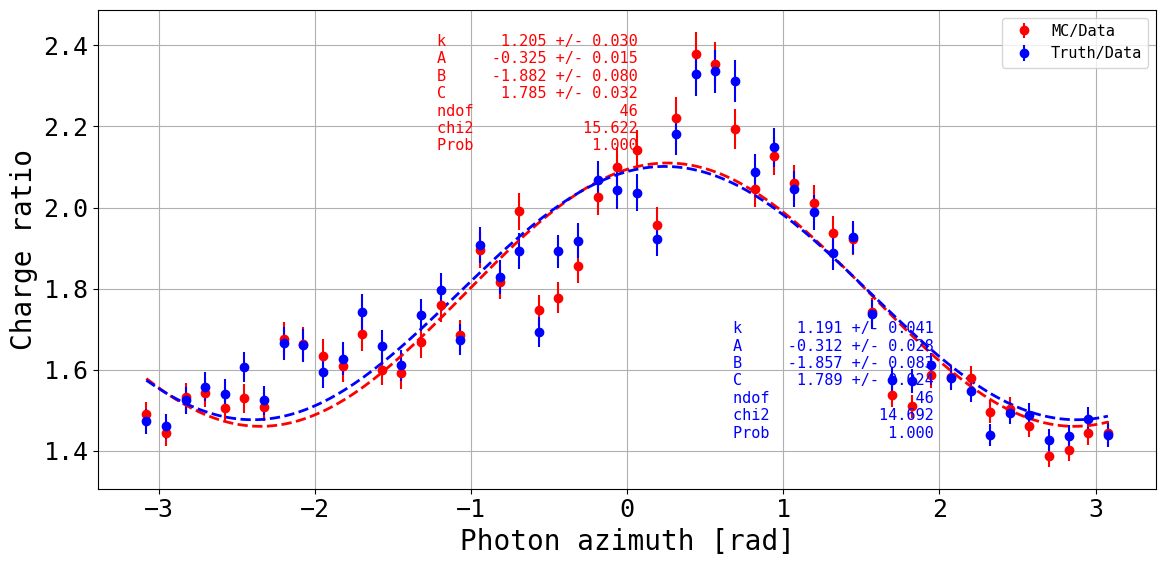

In [45]:

A_init = 0.5
k_init = 2
B_init = -1
C_init = 1


mcrdqw_d  = fit_sine(qmcrdeff,  qmcrdeff_err)
mctrdqw_d = fit_sine(qmctrdeff, qmctrdeff_err)

X = bin_centers#np.linspace(-np.pi,np.pi, nbins)
X2 = np.linspace(bin_centers[0], bin_centers[-1],200)#np.linspace(-np.pi,np.pi, nbins)
fig, ax = plt.subplots(1,1, figsize=(12,6))
c1, c2 = 'r', 'b'
ax.errorbar(X, qmcrdeff,  yerr=qmcrdeff_err, color=c1, fmt ='o', label='MC/Data');
ax.errorbar(X, qmctrdeff, yerr=qmctrdeff_err, color=c2, fmt ='o', label='Truth/Data')

d = mcrdqw_d
ax.plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.32, 0.95, text, ax, fontsize=11, color=c1)

d = mctrdqw_d
ax.plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.6, 0.35, text, ax, fontsize=11, color=c2)

ax.set(xlabel = 'Photon azimuth [rad]', ylabel = 'Charge ratio')
ax.legend(fontsize=11), ax.grid(), plt.tight_layout()
if savefig:
    plt.savefig(plot_folder+'azimuth_charge_ratios.pdf')

Fit has converged.
Fit has converged.


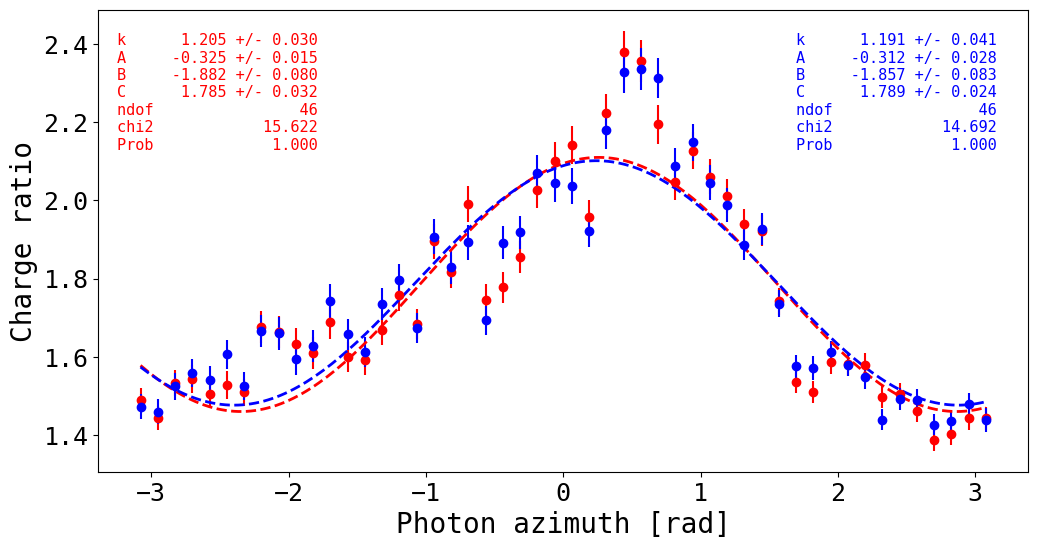

In [46]:
# Slet denne 
A_init = 0.5
k_init = 2
B_init = -1
C_init = 1


mcrdqw_d  = fit_sine(qmcrdeff,  qmcrdeff_err)
mctrdqw_d = fit_sine(qmctrdeff, qmctrdeff_err)

X = bin_centers#np.linspace(-np.pi,np.pi, nbins)
X2 = np.linspace(bin_centers[0], bin_centers[-1],200)#np.linspace(-np.pi,np.pi, nbins)
fig, ax = plt.subplots(1,1, figsize=(12,6))
c1, c2 = 'r', 'b'
ax.errorbar(X, qmcrdeff,  yerr=qmcrdeff_err, color=c1, fmt ='o', label='MC/Data');
ax.errorbar(X, qmctrdeff, yerr=qmctrdeff_err, color=c2, fmt ='o', label='Truth/Data')

d = mcrdqw_d
ax.plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=11, color=c1)

d = mctrdqw_d
ax.plot(X2, sine_func(X2, d['k'][0], d['A'][0], d['B'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.75, 0.95, text, ax, fontsize=11, color=c2)

ax.set(xlabel = 'Photon azimuth [rad]', ylabel = 'Charge ratio')
# ax.legend(fontsize=11), ax.grid(), plt.tight_layout()
if savefig:
    plt.savefig(plot_folder+'azimuth_charge_ratios.pdf')